In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sms
import matplotlib.pyplot as plt
from scipy import stats
import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from sklearn.metrics import mean_absolute_error as mae
from tqdm import tqdm_notebook
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 100)
#df = pd.read_csv('avocado.csv')
df = pd.read_csv('avocado.csv', parse_dates=['Date'], index_col='Date')

In [3]:
df

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-12-27,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-04,7,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
2018-01-28,8,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
2018-01-21,9,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico


# Первичный анализ данных

Датасет продаж авокадо (сорта Хасс) в США в 2015 - 2018 г. 
Значения колонок датасета:
1. Date - дата продажи
2. AveragePrice - средняя цена продажи одного авокадо
3. Total Volume - общее число проданных авокадо
4. 4046 - Число проданных авокадо с продуктовым кодом: 4046, Small Hass Size 60 & smaller (маленький размер, 60 и меньше)
5. 4225 - Число проданных авокадо с продуктовым кодом: 4225, Large Hass Size 40 & 48 (большой размер, 40 и 48)
6. 4770 - Число проданных авокадо с продуктовым кодом: 4770, Extra Large Hass Size 36 & larger (экстра - большой размер, 36 и больше)
7. Total Bags - Общее число проданных пакетов с авокадо (авокадо из пакетов включены в колонку 3)
8. Small Bags - Число проданных маленьких пакетов с авокадо
9. Large Bags - Число проданных больших пакетов с авокадо
10. XLarge Bags - Число проданных экстра - больших пакетов с авокадо
11. type - Технология производства проданных авокадо (conventional - обычная, organic - органическая, с более высокими экологическими стандартами)
12. year - Год продажи
13. Region - город продажи

Датасет взят с kaggle, ссылка на датасет: https://www.kaggle.com/neuromusic/avocado-prices

Расшифровки продуктовых кодов взяты с http://indexfresh.com/retail-foodservice/brands/packaging/plus/

Список городов представленных в датасете:

In [4]:
cities1 = df['region'].unique()
cities = pd.DataFrame({'city' : cities1})
cities

,city
0,Albany
1,Atlanta
2,BaltimoreWashington
3,Boise
4,Boston
5,BuffaloRochester
6,California
7,Charlotte
8,Chicago
9,CincinnatiDayton


Особый интерес представляет значение TotalUs - продажи по США в целом

# Предобработка данных

Проведем предобработку данных - удалим колонку 'Unnamed: 0' - из нее не возможно извлечь данные, также выкинем колонку year.

In [5]:
df.drop(['year','Unnamed: 0'], axis=1, inplace=True)

In [6]:
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,WestTexNewMexico
2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,WestTexNewMexico
2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,WestTexNewMexico


Также хочется удалить колонку 'XLarge Bags' (на первый взгляд кажется, что в ней только нули, проверим это)

In [7]:
df['XLarge Bags'].value_counts()

0.00        12048
3.33           29
6.67           16
1.11           15
5.00           12
            ...  
36.39           1
29342.75        1
724.83          1
7415.42         1
118.86          1
Name: XLarge Bags, Length: 5588, dtype: int64

Нулей 12048, всего строк 18249 - есть 6201 ненулевых значений - не будем удалять

In [11]:
df = df.sort_values(by=['Date'])

# Визуальный анализ данных

Сначала проанализируем данные по США в целом - построим временные ряды для средней цены и объема продаж, при это будем отедьно рассматривать conventional и organic avocado

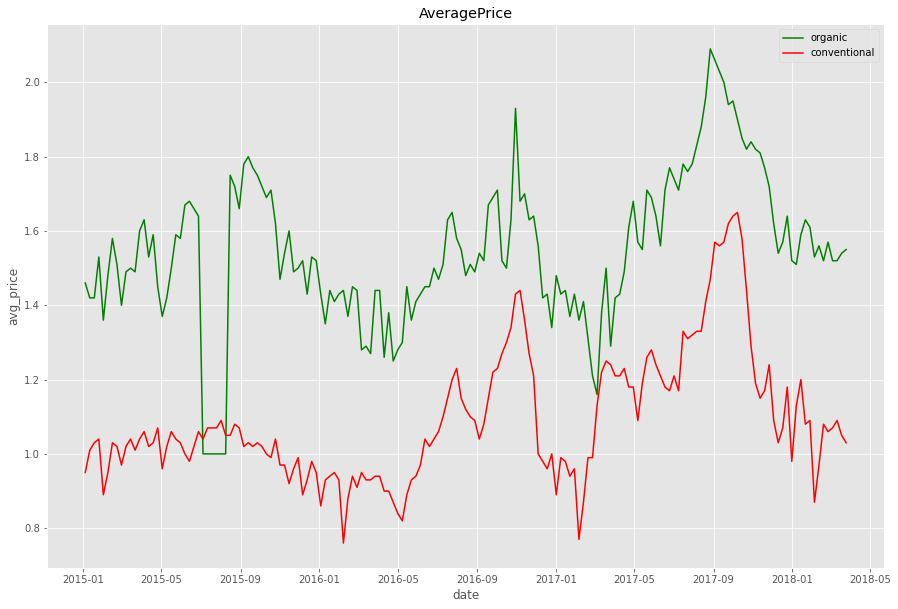

In [12]:
total_org = df[(df.type=='organic')&(df.region=='TotalUS')]
total_conv = df[(df.type=='conventional')&(df.region=='TotalUS')]
plt.figure(figsize = (15,10))
plt.title('AveragePrice')
plt.xlabel('date')
plt.ylabel('avg_price')
plt.plot(total_org.index, total_org.AveragePrice, color = 'green', label = 'organic')
plt.plot(total_conv.index, total_conv.AveragePrice, color = 'red', label = 'conventional')
plt.legend()
plt.show()

In [13]:
total_org

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
Date,,,,,,,,,,,
2015-01-04,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,0.00,organic,TotalUS
2015-01-11,1.42,669528.88,270966.74,260971.60,3830.42,133760.12,106844.49,26915.63,0.00,organic,TotalUS
2015-01-18,1.42,713120.00,254319.58,311811.01,4020.85,142968.56,101850.23,41118.33,0.00,organic,TotalUS
2015-01-25,1.53,556368.86,207494.87,212312.02,4753.87,131808.10,95964.83,35843.27,0.00,organic,TotalUS
2015-02-01,1.36,740896.97,302561.47,259286.44,5852.28,173196.78,129953.15,43243.63,0.00,organic,TotalUS
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-25,1.57,1459852.55,122912.97,340374.83,1063.32,994471.50,765056.82,229158.56,256.12,organic,TotalUS
2018-03-04,1.52,1634430.77,142345.03,390129.50,1225.97,1099871.68,831885.50,267818.31,167.87,organic,TotalUS
2018-03-11,1.52,1664234.88,129169.72,408763.50,1401.87,1124621.50,944572.50,180049.00,0.00,organic,TotalUS


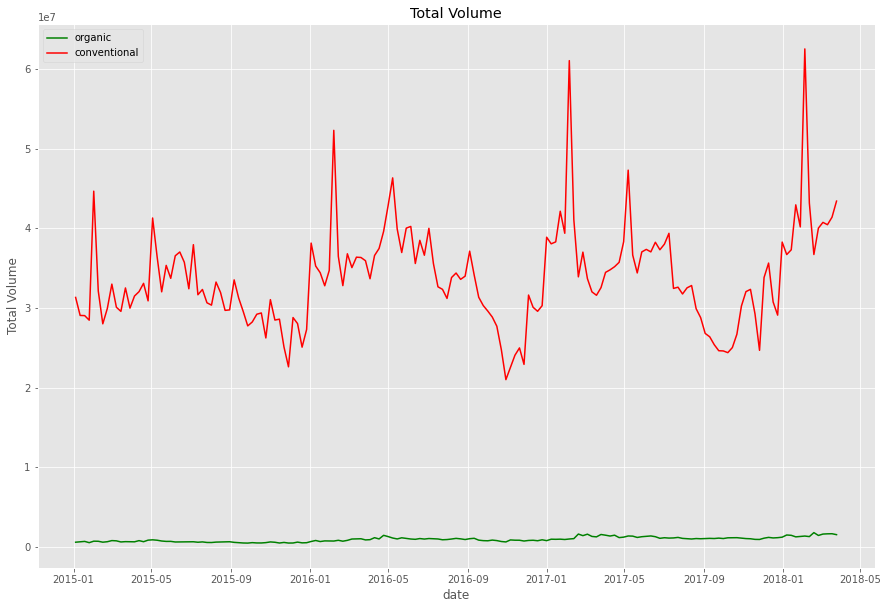

In [17]:
plt.figure(figsize = (15,10))
plt.title('Total Volume')
plt.xlabel('date')
plt.ylabel('Total Volume')
plt.plot(total_org.index, total_org['Total Volume'], color = 'green', label = 'organic')
plt.plot(total_conv.index, total_conv['Total Volume'], color = 'red', label = 'conventional')
plt.legend()
plt.show()

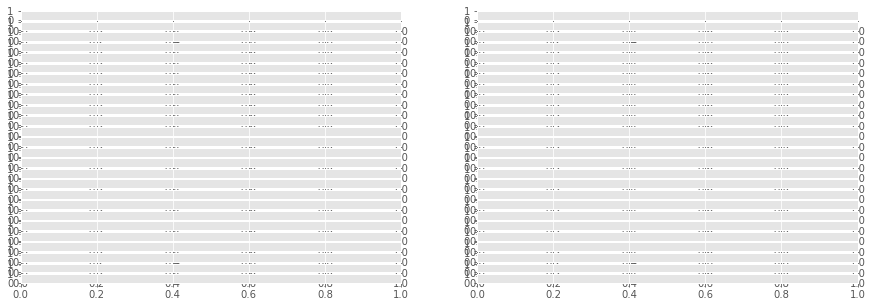

In [19]:
fig, axes = plt.subplots(26, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
#for elem in cities1:

<BarContainer object of 10 artists>

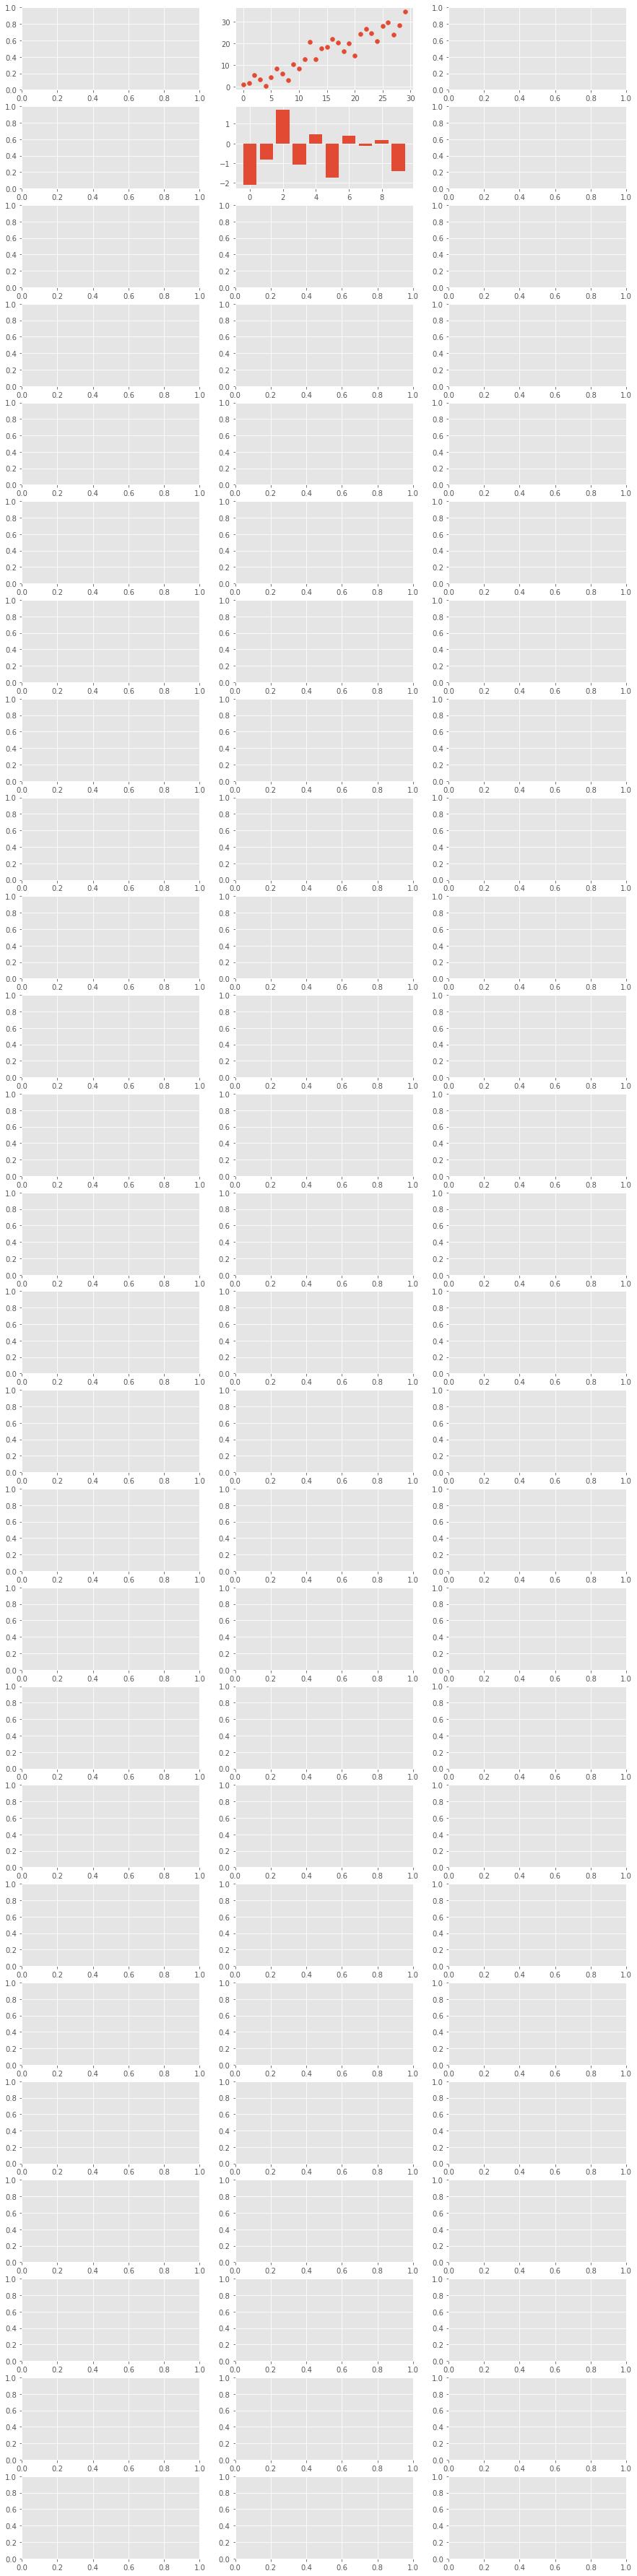

In [24]:
from numpy.random import randn
fig, axes = plt.subplots(26, 3)
fig.set_figheight(65)
fig.set_figwidth(15)

axes[0,1].scatter(np.arange(30), np.arange(30) + 3 * randn(30)) 
axes[1,1].bar(np.arange(10),  randn(10)) 

In [ ]:
total_org.index